# Supplement 1: pH Determination by Spectral Fitting

High-Precision characterisation of indicator dyes by Spectral Fitting: Application to Swawater pH and Alkalinity measurements. Branson & Ellwood. *In Review.*

## Contents
1. [Spectral Fitting by Non Linear Least Squares](#1_specfit)
    1. [Spectral Uncertainties](#1A_specunc)
2. [Propagation of Parameter Uncertainty to pH Uncertainty](#2_eprop)
    1. [Graphic Example of Uncertainty Propagation](#2A_graphic)
    2. [Uncertainty Propagation in Practice](2B_practice)

### Figures
3. [Uncertainty in a pH Measurement](#fig3)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm.notebook import tqdm
from carbspec import dye
from carbspec import spectro
from carbspec.spectro.uncertainty import calc_photometric_error
from scipy import optimize as opt
import uncertainties as un
import uncertainties.unumpy as unp

# L&O plot specs
# https://aslopubs.onlinelibrary.wiley.com/hub/journal/15415856/about/author-guidelines#7
cw = 4  # column width = 3.5 inches
figpath = './figs/'

<a id="1_specfit"></a>
## 1. Spectral Fitting by NonLinear Least Squares

The terms for wavelength calibration ($m$ and $c$) render the spectral fitting problem non-linear.
$$
\lambda_i A = a (m \lambda_i + c) \epsilon_{I} + b (m \lambda_i + c) \epsilon_{HI} + B_0
$$
In this case, the system must be solved by non-linear Least Squares using the Normal Equations, which minimise $\mathbf{\Delta A}$ through:

$$
(\mathbf{J}^T \mathbf{J}) \mathbf{\Delta p} = \mathbf{J}^T \mathbf{\Delta A}
$$

The Jacobian ($\mathbf{J}$) will be a non-square matrix of shape (len($\mathbf{p}$), $n$). To calcualte $\mathbf{J}$ we must determine the partial differential of our equation with respect to each parameter. To do this, we will consider our end-member spectra ($\epsilon_{I}$ and $\epsilon_{HI}$) as functions which return a value given a wavelength ($\lambda_i$):
$$
\lambda_i A = a f_I(m \lambda_i + c) + b f_{HI}(m \lambda_i + c) + B_0
$$
which are each differentiable as $f_I'$ and $f_{HI}'$.

From this, the Jacobian is:
$$
\mathbf{J}_F(a, b, m, c, B_0) = 
\begin{bmatrix}
\frac{\delta \lambda_0 A}{\delta a} & \frac{\delta \lambda_0 A}{\delta b} & \frac{\delta \lambda_0 A}{\delta m} & \frac{\delta \lambda_0 A}{\delta c} & \frac{\delta \lambda_0 A}{\delta B_0} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
\frac{\delta \lambda_n A}{\delta a} & \frac{\delta \lambda_n A}{\delta b} & \frac{\delta \lambda_n A}{\delta m} & \frac{\delta \lambda_n A}{\delta c} & \frac{\delta \lambda_n A}{\delta B_0} \\
\end{bmatrix} =
\begin{bmatrix}
f_I (\lambda_0 m + c) & f_{HI} (\lambda_0 m + c) & \lambda_0 a f_I'(\lambda_0 m + c) + \lambda_0 b f_{HI}'(\lambda_0 m + c) & a f_I'(\lambda_0 m + c) + b f_{HI}'(\lambda_0 m + c) & 1 \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
f_I (\lambda_n m + c) & f_{HI} (\lambda_n m + c) & \lambda_N a f_I'(\lambda_n m + c) + \lambda_N b f_{HI}'(\lambda_0 m + c) & a f_I'(\lambda_N m + c) + b f_{HI}'(\lambda_n m + c) & 1 \\
\end{bmatrix}
$$

Which may be used to solve the non-linear least squares problem using standard methods, for example the [Levenberg-Marquardt algorithm](https://link.springer.com/chapter/10.1007/BFb0067700).

The parameter covariance matrix may then be calculated following the Levenberg-Marquardt approximation:
$$
\mathbf{C_p} = \frac{RSS}{dof} (\mathbf{J}^T \mathbf{J})^{-1}
$$
From this, it is evident that uncertainties will be directly proportional to noise in the spectra, and inversely proportional to $n$ ($dof$).

<a id="1A_specunc"></a>
## 1A. Spectral Uncertainties
Uncertainties in the spectral data may be incorporated as a diagonal weight matrix, $\mathbf{W}$:
$$
(\mathbf{J}^T \mathbf{W J}) \mathbf{\Delta p} = \mathbf{J}^T \mathbf{W \Delta A}
$$
where:
$$
\mathbf{W} = \frac{1}{\sigma^2} \mathbf{I_n}
$$
Where $\mathbf{I_n}$ is the identity matrix.

In an idealised case, noise may be approximated as uniform across the absorption spectrum (a single $\sigma^2$ value).

Alternatively, the noise may be more accurately determined for a given spectrophotometer system using [well-known equations](https://pubs.acs.org/doi/pdfplus/10.1021/ac071933h) for thermal noise, photon noise and cell position fluctuations:

$$
\begin{align}
\frac{\sigma_{Abs}}{Abs} = \frac{0.434}{Abs} \frac{\sigma_T}{10^{-Abs}} \\ 
\sigma_T^{Thermal} = k_1 \sqrt{1 + 10^{-2 Abs}} \\
\sigma_T^{Photon} = k_2 \sqrt{10^{-Abs} + 10^{-2 Abs}} \\
\sigma_T^{CellPos} = k_3 10^{-Abs} \\
\frac{\sigma_{Abs}^{Combined}}{Abs} = \sqrt{\sum_i{\left( \frac{\sigma_{Abs}^j}{Abs} \right)_i^2}}
\end{align}
$$
From which a $\lambda$-dependant $\sigma^2$ may be calculated and used as a weight matrix:
$$
\mathbf{W} = \frac{1}{\sigma^2_{\lambda}} \mathbf{I_n}
$$

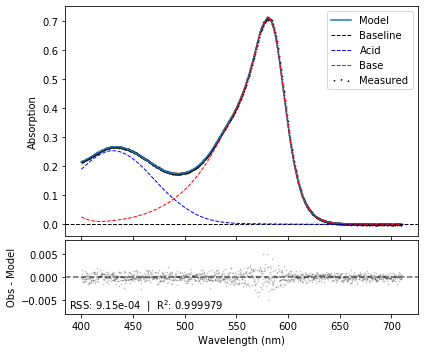

In [2]:
np.random.seed(3)  # for reproducibility

# make synthetic spectrum
mix = spectro.mixture.make_mix_spectra('BPB')
xtrue = np.random.uniform([0, 0, -0.02, -20, 0.98], 
                          [1, 1, 0.05, 20, 1.02])  # a, b, bkg, c, m
wv = np.linspace(400, 710, 1200)
Abs = mix(wv, *xtrue)
sigma = calc_photometric_error(Abs, 8.8e-4)
Abs += np.random.normal(0, abs(sigma))

# fit spectrum
p, cov = spectro.unmix_spectra(wv, Abs, 'BPB', sigma)
sd = np.sqrt(np.diag(cov))

# plot fit
_ = spectro.plot_mixture(wv, Abs, 'BPB', p)

Text(0.5, 1.0, 'Ability to Resolve True Parameters')

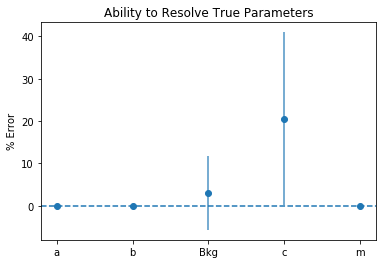

In [3]:
# ability to recover true parameters
plt.scatter(range(p.size), 100 * (xtrue - p) / xtrue)
plt.errorbar(range(p.size), 100 * (xtrue - p) / xtrue, 100 * sd / xtrue, lw=0, elinewidth=2, alpha=0.6)
plt.axhline(0, ls='dashed')
plt.ylabel('% Error')
plt.xticks(range(p.size), ['a', 'b', 'Bkg', 'c', 'm'])
plt.title('Ability to Resolve True Parameters')

<a id="2_eprop"></a>
## 2. Propagation of Parameter Uncertainty to pH Uncertainty

Once the covariance matrix is determined, these uncertainties can be propagated through to $F$:
$$
\begin{align}
\sigma_{F} &= \left|F\right| \sqrt{\left[ \left(\frac{\sigma_a}{a} \right)^2 + \left(\frac{\sigma_b}{b} \right)^2 - \left(\frac{\sigma_{ab}}{a b} \right) \right]}
\end{align}
$$
and the restulting pH estimate:
$$
\begin{align}
\sigma_{K_I/H} &= \left| \frac{K_I}{F} \right| \sqrt{\left( \frac{\sigma_F}{F} \right)^2} \\
\sigma_{pH} &= \left| \frac{\sigma_{K_I/H}}{\frac{K_I}{H} \ln(10)} \right|
\end{align}
$$

The propagation of $a$ and $b$ uncertainties to pH produces a non-linear uncertainty response, which increases away from an optimum pH. The optimal measurement pH is distinct from the dye $pK$ value, because the end-member spectra are of unequal area so have different power in the least squares. This will be different for each dye considered. The increase in uncertainty away from this optimum will be exacerbated in the presence of greater noise or fewer samples, which will increase the uncertainty in the minor component of the spectrum, producing large propagated errors. From this characterisation, it is possible to optimise the spectral characteristics required for pH mesaurements within a given range for a given dye.


<a id="2A_graphic"></a>
### 2A. Graphic Example of Uncertainty Propagation

Here we calculate the propagated uncertainty across a range of noise levels and for simulated solutions across a range of pH values.
This demonstrates how the uncertainty in the calculated pH measurement changes as a function of these key variables.

In [4]:
from carbspec.spectro.fitting import obj_fn, Jacobian, guess_p0

aspl, bspl = dye.spline_handler('BPB')

wv = np.linspace(350, 700, 1200)
ipHs = np.linspace(2.33, 4.33, 50)
inoise_stds = np.logspace(-3, -1, 50)
pHs, noise_stds = np.meshgrid(ipHs, inoise_stds)

ups = []
As = []

pstart = [0.1, 0.1, 0, 0, 1]
bounds=((0, 0, -np.inf, -20, 0.98), (np.inf, np.inf, np.inf, 20, 1.02))

for pH in tqdm(ipHs, total=pHs.shape[0]):
    H = 10**-pH    
    A = spectro.mixture.spec_from_pH(0.99 * wv + 10, pH, 1, 'BPB')
    As.append(A)

    for noise_std in inoise_stds:
        fit = opt.least_squares(obj_fn, guess_p0(wv, A, aspl, bspl), jac=Jacobian, 
                                kwargs=dict(wv=wv, Abs=A, sigma=noise_std, aspl=aspl, bspl=bspl, daspl=aspl.derivative(), dbspl=bspl.derivative()))
        cov = np.linalg.inv(fit.jac.T.dot(fit.jac))  # jacobian is already scaled by sigma
        ups.append(un.correlated_values(fit.x, cov))

ups = np.array(ups)
As = np.array(As)
Fs = ups[:,1] / ups[:,0]

Kdye = dye.K_handler('BPB', temp=25, sal=35)
pH_pred = spectro.mixture.pH_from_F(Fs, Kdye).reshape(pHs.shape).T

# save predicted pH for use in TA Calculation
np.save('./data/pH_pred.npy', pH_pred)

<a id="fig3"></a>

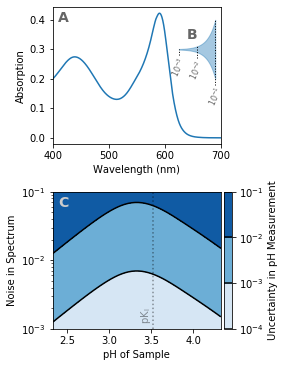

In [5]:
fig, axs = plt.subplots(2, 1, figsize=[cw, 1.3 * cw])

sax, eax = axs

midspec = spectro.mixture.spec_from_pH(wv, 3.37816327, 1, 'BPB')
sax.plot(wv, midspec)
sax.set_xlim(400, 700)

x0 = 625
x1 = 690
y0 = 0.3
i = 0
nx = np.linspace(x0, x1)
sax.fill_between(nx, y0 - inoise_stds, y0 + inoise_stds, color='C0', alpha=0.4)

i = 0
for noise_std in [1e-3, 1e-2, 1e-1]:
    sax.plot([x0 + i, x0 + i], [y0 - 0.02 - noise_std, y0 + noise_std], color='k', ls='dotted', lw=1)
    sax.text(x0 + i, y0 - 0.02 - noise_std, '$10^{' + f'{np.log10(noise_std):.0f}' + '}$', rotation=65, fontsize=8, ha='center', va='top', alpha=0.6)
    i += (x1 - x0) / 2
    
levels = np.logspace(-4, -1, 4)
linestyles = ['solid']
cm = eax.contourf(pHs, noise_stds, unp.std_devs(pH_pred), levels, cmap=plt.cm.Blues, norm=colors.LogNorm(vmin=min(levels), vmax=max(levels)))
# eax.colorbar(label='Uncertainty in pH Measurement')
eax.contour(pHs, noise_stds, unp.std_devs(pH_pred), levels, linestyles=linestyles, colors=['k'])

eax.set_yscale('log')

sax.set_ylabel('Absorption')
sax.set_xlabel('Wavelength (nm)')
eax.set_xlabel('pH of Sample')
eax.set_ylabel('Noise in Spectrum')

fig.tight_layout(rect=[0, 0, .85, 1])

epos = eax.get_position()
cax = fig.add_axes([epos.x1 + 0.01, epos.y0, 0.03, epos.height])
fig.colorbar(cm, cax=cax, label='Uncertainty in pH Measurement')
for line in np.linspace(0, 1, len(levels)):
    cax.axhline(line, color='k')

cax.set_yticklabels(['$10^{' + f'{np.log10(c):.0f}' + '}$' for c in levels])
    
for ax, lab, c in zip([sax, eax], 'AC', [(.4,.4,.4), (.8, .8, .8)]):
    ax.text(0.03, 0.97, lab, ha='left', va='top', transform=ax.transAxes, color=c, weight='bold', fontsize=14)

sax.text(0.8, 0.85, 'B', ha='left', va='top', transform=sax.transAxes, color=(.4,.4,.4), weight='bold', fontsize=14)

pKdye = -np.log10(Kdye)
eax.axvline(pKdye, ls='dotted', c=(0,0,0,0.4))
eax.text(pKdye, 9.5**-3, '$pK_{I}$', rotation=90, ha='right', va='bottom', color=(0,0,0,0.4))
    
fig.savefig(figpath + '3_errorprop.pdf')

**Figure 3:** The propagation of uncertainty from a BPB dye spectrum to the calculated pH as a function of spectral noise and sample pH. A simulated sample spectrum at the optimal dye pH (A) is shown with an indicator of noise standard deviation (B) explored in the error analysis. The uncertainty in a pH measurement resulting from least-squares fitting is shown as a function of both noise level and sample pH (C). Under normal operating conditions noise in the spectrum should be well below $10^{-2}$. Calculations are for a spectrometer measuring 1200 data points across the spectrum.

<a id="2B_practice"></a>
### 2B. Uncertainty In Practice

Here, we show the ability to resolve a start pH in a noisy spectrum, which is handled automatically by ``carbspec``.

True pH:   3.432
Meas pH:   3.427+/-0.003
Diff:      0.005+/-0.003


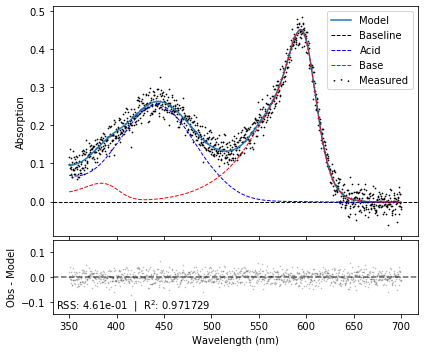

In [6]:
np.random.seed(3)  # for reproducibility

# generate random spectrum
noise_std = np.asanyarray(0.02)  # random noise level
pH = np.random.uniform(2.33, 4.33)  # random sample pH
m, c = np.random.uniform([0.98, -20], [1.02, 20])  # random wavelength offsets
A = spectro.mixture.spec_from_pH(m * wv + c, pH, 1, 'BPB') + np.random.normal(0, noise_std, wv.shape)  # generate spectrum

# fit and plot spectrum
pH_meas = spectro.pH_from_spectrum(wv, A, dye='BPB')
spectro.plot_mixture(wv, A, dye='BPB')

print(f'True pH:   {pH:.3f}\nMeas pH:   {pH_meas:.3f}\nDiff:      {pH - pH_meas:.3f}')